In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qick import *
from qick.asm_v2 import AveragerProgramV2, QickSpan, QickSweep1D
from qick.pyro import make_proxy
from tqdm import tqdm
#from slab import experiment

soc, soccfg = make_proxy(ns_host="192.168.137.8", ns_port=8884, proxy_name="chatot")
print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8884
chatot PYRO:obj_17c385afbe674a538ad00f483e931027@192.168.137.104:33513
QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Sat Sep 28 22:15:40 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.838 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (3.419 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 

In [2]:
GEN_CH = 0
RO_CH = 0
TRIG_TIME = 0.40
FREQ = 5200

## Time of Flight

In [6]:
class TimeOfFlight(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2,
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1, 
                      )

    def _body(self, cfg):
            self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
            self.pulse(ch=cfg['gen_ch'], name="pulse", t=0)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': 0,
          'ro_len': 1,
         }

prog = TimeOfFlight(soccfg, reps=1, final_delay=0.5, cfg=config)


iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)
mag = np.abs(iq_list[0].dot([1,1j]))

plt.plot(t, mag, label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

tof = t[np.argmax(np.diff(mag)) + 1]
plt.axvline(x=tof, linestyle="--", color='r')
plt.title("Time of Flight: " + str(tof) + "us")
TRIG_TIME = tof

Traceback (most recent call last):
  File "C:\Users\csnipp\Documents\charles_qick\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\csnipp\AppData\Local\Temp\5\ipykernel_10908\1928178686.py", line 28, in <module>
    prog = TimeOfFlight(soccfg, reps=1, final_delay=0.5, cfg=config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\csnipp\Documents\charles_qick\Lib\site-packages\qick\asm_v2.py", line 2408, in __init__
    self.compile()
  File "C:\Users\csnipp\Documents\charles_qick\Lib\site-packages\qick\asm_v2.py", line 2425, in compile
    self.make_program()
  File "C:\Users\csnipp\Documents\charles_qick\Lib\site-packages\qick\asm_v2.py", line 2495, in make_program
    self._initialize(self.cfg)
  File "C:\Users\csnipp\AppData\Local\Temp\5\ipykernel_10908\1928178686.py", line 7, in _initialize
    self.declare_readout(ch=ro_ch, length=cfg['ro_len'], fre

## Time of Flight, tProcv2 readout

  0%|          | 0/5000 [00:00<?, ?it/s]

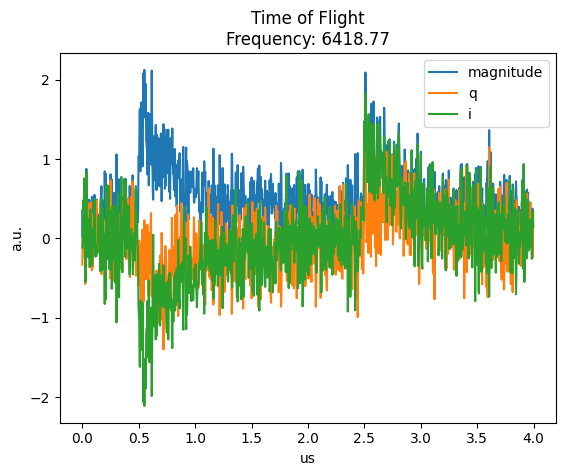

In [63]:
class TimeOfFlight(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name='ro', freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=2,
                       freq=cfg['freq'], 
                       phase=0,
                       gain=cfg['gain'], 
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name='ro', t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="pulse", t=0)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': 6418.77,
          'trig_time': 0,
          'ro_len': 4,
          'gain': 0.8
         }

prog = TimeOfFlight(soccfg, reps=1, final_delay=None, cfg=config)


iq_list = prog.acquire_decimated(soc, soft_avgs=5000)
t = prog.get_time_axis(ro_index=0)
i = iq_list[0][:,0]
q = iq_list[0][:,1]
mag = np.abs(iq_list[0].dot([1,1j]))

plt.plot(t, mag, label="magnitude")
plt.plot(t, q, label="q")
plt.plot(t, i, label="i")


plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")
plt.title("Time of Flight\nFrequency: " + str(config['freq']))

TRIG_TIME = 0.5

## Single tone (Resonator) Spectroscopy, software looping

In [17]:
class FrequencySpectroscopy(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2,
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1, 
                      )

    def _body(self, cfg):
            self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
            self.pulse(ch=cfg['gen_ch'], name="pulse", t=0)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 0.01,
         }

start = 20
stop = 990
step = 1
fs = np.arange(start, stop, step)
amps = []

for f in tqdm(fs):
    config['freq'] = f
    singlepoint = FrequencySpectroscopy(soccfg, reps=2, final_delay=0.5, cfg=config)
    iq_list = singlepoint.acquire(soc, soft_avgs=1)
    amp = np.abs(iq_list[0][0].dot([1,1j]))
    amps.append(amp)

plt.plot(fs, amps, 'o')
plt.xlabel("Frequency, MHz")
plt.ylabel("a.u.")
plt.title("Frequency Spectroscopy")
plt.show()

  0%|                                                                                          | 0/970 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\csnipp\Documents\charles_qick\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\csnipp\AppData\Local\Temp\15\ipykernel_1476\985488159.py", line 36, in <module>
    singlepoint = FrequencySpectroscopy(soccfg, reps=2, final_delay=0.5, cfg=config)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\csnipp\Documents\charles_qick\Lib\site-packages\qick\asm_v2.py", line 2408, in __init__
    self.compile()
  File "C:\Users\csnipp\Documents\charles_qick\Lib\site-packages\qick\asm_v2.py", line 2425, in compile
    self.make_program()
  File "C:\Users\csnipp\Documents\charles_qick\Lib\site-packages\qick\asm_v2.py", line 2495, in make_program
    self._initialize(self.cfg)
  File "C

## Single tone frequency scan, firmware looping

  0%|          | 0/1000000 [00:00<?, ?it/s]

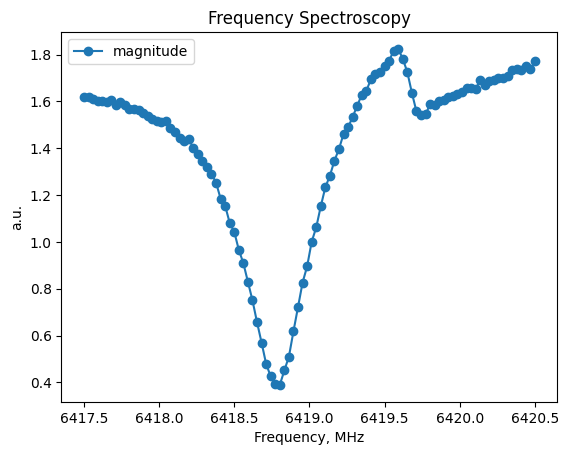

In [54]:
# a tProc configured ADC channel is required here
class SinglePulseFreqLoop(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop(name='freq_loop', count=cfg['steps'])
        self.add_readoutconfig(ch=ro_ch, name='ro', freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'], 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name='ro', t=0)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

f0 = 6419
span = 1.5
n = 100
fs = np.linspace(f0 - span, f0 + span, n)

pulse_len = 3

config = {'gen_ch': 0,
          'ro_ch': 0,
          'freq': QickSweep1D('freq_loop', f0 - span, f0 + span),
          'trig_time': TRIG_TIME,
          'pulse_len': pulse_len,
          'ro_len': pulse_len,
          'steps': n
         }



prog = SinglePulseFreqLoop(soccfg, reps=10000, final_delay=0.5, cfg=config)

iq_list = prog.acquire(soc)
idata = iq_list[0][0][:,0]
qdata = iq_list[0][0][:,1]
adata = np.abs(iq_list[0][0].dot([1,1j]))

# plt.plot(fs, idata, "-o", label="I value")
# plt.plot(fs, qdata, "-o", label="Q value")
plt.plot(fs, adata, "-o", label="magnitude")
plt.legend()
plt.xlabel("Frequency, MHz")
plt.ylabel("a.u.")
plt.title("Frequency Spectroscopy")
plt.show()


## Frequency-Power Scan
this setup is very much temporary

In [50]:
class FreqPowerScan(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop(name='gain_loop', count=cfg['gsteps'])
        self.add_loop(name='freq_loop', count=cfg['fsteps'])
        self.add_readoutconfig(ch=ro_ch, name='ro', freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'], 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=cfg['gain'],
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name='ro', t=0)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

f0 = 6419
span = 1.5
f_n = 50
g_n = 10
fs = np.linspace(f0 - span, f0 + span, f_n)
gs = np.linspace(0, 1, g_n)

pulse_len = 3

config = {'gen_ch': 0,
          'ro_ch': 0,
          'freq': QickSweep1D('freq_loop', f0 - span, f0 + span),
          'trig_time': TRIG_TIME,
          'pulse_len': pulse_len,
          'ro_len': pulse_len,
          'fsteps': f_n,
          'gsteps': g_n,
          'gain': QickSweep1D('gain_loop', 0, 1)
         }



prog = FreqPowerScan(soccfg, reps=5000, final_delay=0.5, cfg=config)

iq_list = prog.acquire(soc)
adata = []
for iq in range(len(iq_list[0][0])):
    adata.append(np.abs(iq_list[0][0][iq].dot([1,1j])))



  0%|          | 0/2500000 [00:00<?, ?it/s]

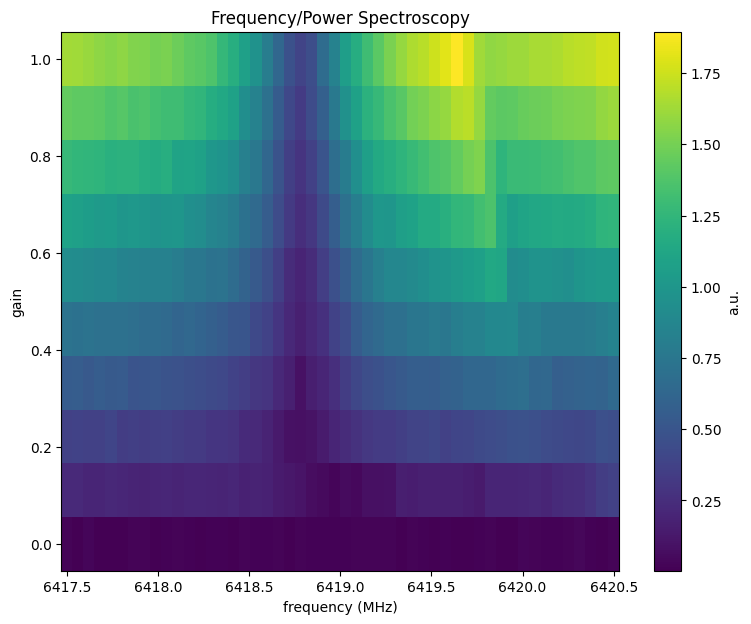

In [52]:
fig = plt.figure(figsize=(9, 7))
plt.title("Frequency/Power Spectroscopy")
plt.pcolor(fs, gs, adata)
cbar = plt.colorbar()
cbar.set_label("a.u.")
plt.xlabel("frequency (MHz)")
plt.ylabel("gain")
plt.show()

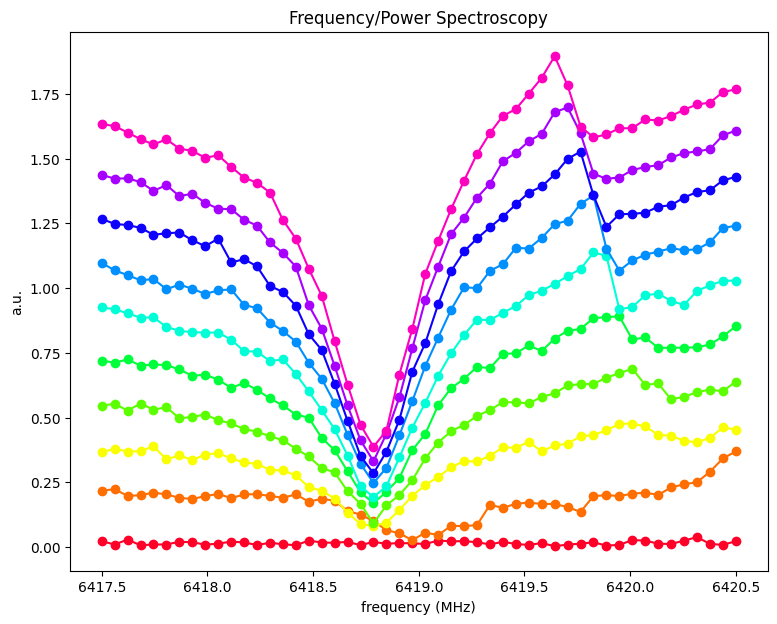

In [53]:
fig = plt.figure(figsize=(9, 7))
plt.title("Frequency/Power Spectroscopy")
colors = plt.cm.gist_rainbow(np.linspace(0, 1, g_n))
for i, color in enumerate(colors):
    plt.plot(fs, adata[i], "-o", color=color)
plt.xlabel("frequency (MHz)")
plt.ylabel("a.u.")
plt.show()